# Import some Libraries

In [1]:
import os
import time
from datetime import datetime

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso   
from sklearn.svm import SVR

import keras
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


from sklearn.metrics import r2_score

# for mape
def mape(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

# for smape
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))

# per hour mae
def per_hour_mae(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    return np.abs(y_true - y_pred)

import warnings
warnings.filterwarnings("ignore")

# Target site testing with domain adaptation by airport pretrained model

In [2]:
def target_domain_adaptation_testing(name_list):
    '''
    Input:- give input and output pairs at different site with base+derived features
    Output:- calibrated results at different sites with domain adaptation at target sites
    '''
    # base+derived features path
    base_derived_data_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\data\base_derived_features'
    
    # source site name
    source_site = 'Airport'
    
    for name in name_list:
        
        print('Site Name:', name)
        # read data files
        df_name = pd.read_csv(base_derived_data_path + '/base_derived_innu_outu_startupA_'+name+'.csv')
        
        # convert date into standard format
        df_name.Date = pd.to_datetime(df_name.Date,dayfirst=True)
        
        # prepare training, validation and testing data pairs
        a = 168 # 2days data for training
        b = 336 # 1 week data for validation
        c = 1056 # 1 month data for testing
        d = df_name.shape[0] # next data for testing
        
        # prepare set for train, val and test date
        train_date = df_name.iloc[120:a,0:1].values
        val_date = df_name.iloc[a:b,0:1].values
        test_date1 = df_name.iloc[b:c,0:1].values
        test_date2 = df_name.iloc[c:d,0:1].values
        
        # prepare set for train, val and test uncalibrated PM2.5
        train_lowcost = df_name.iloc[120:a,2:3].values
        val_lowcost = df_name.iloc[a:b,2:3].values
        test_lowcost1 = df_name.iloc[b:c,2:3].values
        test_lowcost2 = df_name.iloc[c:d,2:3].values
        
        # normalize the input features
        innu = df_name.drop(['Date','PM25','hour','hour_sin','hour_cos'],axis=1)
        outu = df_name[['Date','PM25','hour_sin','hour_cos']]
        innu_scaled = StandardScaler().fit_transform(innu.values)
        innu_scaled_df = pd.DataFrame(innu_scaled, index=innu.index, columns=innu.columns)
        df1 = pd.concat([outu,innu_scaled_df],axis=1)
        innu1 = df1.drop(['Date','PM25'],axis=1)
        outu1 = df1[['PM25']]
        innu_f1 = innu1.iloc[:,:].values
        outu_f1 = outu1.iloc[:,:].values
        
        # prepare training, validation and testing data pairs in 2D
        X_train = innu_f1[120:a,:].astype(np.float32)
        y_train = outu_f1[120:a,:].astype(np.float32)
        X_val = innu_f1[a:b,:].astype(np.float32)
        y_val = outu_f1[a:b,:].astype(np.float32)
        X_test1 = innu_f1[b:c,:].astype(np.float32)
        y_test1 = outu_f1[b:c,:].astype(np.float32)
        X_test2 = innu_f1[c:d,:].astype(np.float32)
        y_test2 = outu_f1[c:d,:].astype(np.float32)
        
        # prepare training, validation and testing data pairs in 1D
        X_train_1d = X_train.reshape(X_train.shape[0],X_train.shape[1])
        y_train_1d = y_train.reshape(y_train.shape[0],)
        X_val_1d = X_val.reshape(X_val.shape[0],X_val.shape[1])
        y_val_1d = y_val.reshape(y_val.shape[0],)
        X_test1_1d = X_test1.reshape(X_test1.shape[0],X_test1.shape[1])
        y_test1_1d = y_test1.reshape(y_test1.shape[0],)
        X_test2_1d = X_test2.reshape(X_test2.shape[0],X_test2.shape[1])
        y_test2_1d = y_test2.reshape(y_test2.shape[0],)
        
        # Uncalibrated performance
        unc_accuracy = pd.DataFrame({
        'Parameters': ['R2_train','MAPE(%)_train','SMAPE(%)_train','R2_val','MAPE(%)_val','SMAPE(%)_val',
                   'R2_test1','MAPE(%)_test1','SMAPE(%)_test1','R2_test2','MAPE(%)_test2','SMAPE(%)_test2'],
         'unc': [ r2_score(y_train,train_lowcost),mape(y_train,train_lowcost),smape(y_train,train_lowcost), 
                 r2_score(y_val,val_lowcost),mape(y_val,val_lowcost), smape(y_val,val_lowcost),
                 r2_score(y_test1,test_lowcost1),mape(y_test1,test_lowcost1),smape(y_test1,test_lowcost1),
                 r2_score(y_test2,test_lowcost2),mape(y_test2,test_lowcost2),smape(y_test2,test_lowcost2)]})
        unc_accuracy=unc_accuracy.transpose()
        
        # base model path
        base_model_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\models\base+derived_features_model'
        
        # domain adaptation model save path
        da_model_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\models\domain_adaptation_model'
        
        # Calibration using LinearRegression (lr)
        lr = pickle.load(open(base_model_path + '\lr_model_' + source_site + '.sav', 'rb'))
        lr.fit(X_train_1d,y_train_1d)
        lr_pred_train = lr.predict(X_train_1d)
        lr_pred_val = lr.predict(X_val_1d)
        lr_pred_test1 = lr.predict(X_test1_1d)
        lr_pred_test2 = lr.predict(X_test2_1d)
        
        # Calibrated results using lr
        lr_accuracy = pd.DataFrame({
        'lr': [ r2_score(y_train_1d,lr_pred_train),mape(y_train_1d,lr_pred_train),smape(y_train_1d,lr_pred_train), 
                 r2_score(y_val_1d,lr_pred_val),mape(y_val_1d,lr_pred_val), smape(y_val_1d,lr_pred_val),
                 r2_score(y_test1_1d,lr_pred_test1),mape(y_test1_1d,lr_pred_test1),smape(y_test1_1d,lr_pred_test1),
                 r2_score(y_test2_1d,lr_pred_test2),mape(y_test2_1d,lr_pred_test2),smape(y_test2_1d,lr_pred_test2)]})
        lr_accuracy=lr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(lr, open(da_model_path + '\lr_model_' + source_site+ 'to' + name + '.sav','wb'))
        
        # Calibration using Support Vector Regression (svr)
        svr = pickle.load(open(base_model_path + '\svr_model_' + source_site + '.sav', 'rb'))
        svr.fit(X_train_1d,y_train_1d)
        svr_pred_train = svr.predict(X_train_1d)
        svr_pred_val = svr.predict(X_val_1d)
        svr_pred_test1 = svr.predict(X_test1_1d)
        svr_pred_test2 = svr.predict(X_test2_1d)
        
        # Calibrated results using svr
        svr_accuracy = pd.DataFrame({
        'svr': [ r2_score(y_train_1d,svr_pred_train),mape(y_train_1d,svr_pred_train),smape(y_train_1d,svr_pred_train), 
                 r2_score(y_val_1d,svr_pred_val),mape(y_val_1d,svr_pred_val), smape(y_val_1d,svr_pred_val),
                 r2_score(y_test1_1d,svr_pred_test1),mape(y_test1_1d,svr_pred_test1),smape(y_test1_1d,svr_pred_test1),
                 r2_score(y_test2_1d,svr_pred_test2),mape(y_test2_1d,svr_pred_test2),smape(y_test2_1d,svr_pred_test2)]})
        svr_accuracy=svr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(svr, open(da_model_path + '\svr_model_' + source_site+ 'to' + name + '.sav','wb'))
        
        # Calibration using Elastic Net Regression (enr)
        enr = pickle.load(open(base_model_path + '\enr_model_' + source_site + '.sav', 'rb'))
        enr.fit(X_train_1d,y_train_1d)
        enr_pred_train = enr.predict(X_train_1d)
        enr_pred_val = enr.predict(X_val_1d)
        enr_pred_test1 = enr.predict(X_test1_1d)
        enr_pred_test2 = enr.predict(X_test2_1d)
        
        # Calibrated results using enr
        enr_accuracy = pd.DataFrame({
        'enr': [ r2_score(y_train_1d,enr_pred_train),mape(y_train_1d,enr_pred_train),smape(y_train_1d,enr_pred_train), 
                 r2_score(y_val_1d,enr_pred_val),mape(y_val_1d,enr_pred_val), smape(y_val_1d,enr_pred_val),
                 r2_score(y_test1_1d,enr_pred_test1),mape(y_test1_1d,enr_pred_test1),smape(y_test1_1d,enr_pred_test1),
                 r2_score(y_test2_1d,enr_pred_test2),mape(y_test2_1d,enr_pred_test2),smape(y_test2_1d,enr_pred_test2)]})
        enr_accuracy=enr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(enr, open(da_model_path + '\enr_model_' + source_site+ 'to' + name + '.sav','wb'))
        
        # Calibration using Ridge Regression (rr)
        rr = pickle.load(open(base_model_path + '/rr_model_' + source_site + '.sav', 'rb'))
        rr.fit(X_train_1d,y_train_1d)
        rr_pred_train = rr.predict(X_train_1d)
        rr_pred_val = rr.predict(X_val_1d)
        rr_pred_test1 = rr.predict(X_test1_1d)
        rr_pred_test2 = rr.predict(X_test2_1d)
        
        # Calibrated results using rr
        rr_accuracy = pd.DataFrame({
        'rr': [ r2_score(y_train_1d,rr_pred_train),mape(y_train_1d,rr_pred_train),smape(y_train_1d,rr_pred_train), 
                 r2_score(y_val_1d,rr_pred_val),mape(y_val_1d,rr_pred_val), smape(y_val_1d,rr_pred_val),
                 r2_score(y_test1_1d,rr_pred_test1),mape(y_test1_1d,rr_pred_test1),smape(y_test1_1d,rr_pred_test1),
                 r2_score(y_test2_1d,rr_pred_test2),mape(y_test2_1d,rr_pred_test2),smape(y_test2_1d,rr_pred_test2)]})
        rr_accuracy=rr_accuracy.transpose()
        
        # save the trained model
        pickle.dump(rr, open(da_model_path + '/rr_model_' + source_site+ 'to' + name + '.sav','wb'))
        
        # Calibration using Lasso Regression (lar)
        lar = pickle.load(open(base_model_path + '\lar_model_' + source_site + '.sav', 'rb'))
        lar.fit(X_train_1d,y_train_1d)
        lar_pred_train = lar.predict(X_train_1d)
        lar_pred_val = lar.predict(X_val_1d)
        lar_pred_test1 = lar.predict(X_test1_1d)
        lar_pred_test2 = lar.predict(X_test2_1d)
        
        # Calibrated results using lar 
        lar_accuracy = pd.DataFrame({
        'lar': [ r2_score(y_train_1d,lar_pred_train),mape(y_train_1d,lar_pred_train),smape(y_train_1d,lar_pred_train), 
                 r2_score(y_val_1d,lar_pred_val),mape(y_val_1d,lar_pred_val), smape(y_val_1d,lar_pred_val),
                 r2_score(y_test1_1d,lar_pred_test1),mape(y_test1_1d,lar_pred_test1),smape(y_test1_1d,lar_pred_test1),
                 r2_score(y_test2_1d,lar_pred_test2),mape(y_test2_1d,lar_pred_test2),smape(y_test2_1d,lar_pred_test2)]})
        lar_accuracy=lar_accuracy.transpose()
        
        # save the trained model
        pickle.dump(lar, open(da_model_path + '\lar_model_' + source_site+ 'to' + name + '.sav','wb'))
        
        # Calibration using Dense Neural Network (dnn)
        dnn = models.load_model(base_model_path + '\dnn_model_' + source_site + '.h5')
        
        # 1st step: freeze the pretrained layer and train the layers added on the top of base model dnn 
        # by using 2days data at target site
        
        dnn.include_top = False
        dnn.trainable = False
        
        inputs = keras.Input(shape=(X_train.shape[1],))
        x = dnn(inputs, training=False)
        x = keras.layers.Dense(8,kernel_initializer='normal',activation='relu')(x)
        outputs = keras.layers.Dense(1)(x)
        dnn = keras.Model(inputs, outputs)
        early_stopping = EarlyStopping(monitor ="val_loss", mode ="min", patience = 100,
                                       restore_best_weights = True)
        dnn.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-1), metrics=['mse'])
        history = dnn.fit(X_train, y_train, epochs=2000,
                  validation_data = (X_val,y_val), callbacks=[early_stopping])
        
        # testing the accuracy by 1st step of the domain adaptation (DA)
        dnn_pred_train = dnn.predict(X_train)
        dnn_pred_val = dnn.predict(X_val)
        dnn_pred_test1 = dnn.predict(X_test1)
        dnn_pred_test2 = dnn.predict(X_test2)
        
        # calibrating accuracy by 1st step of DA
        dnn_accuracy_1 = pd.DataFrame({
        'dnn': [r2_score(y_train,dnn_pred_train),mape(y_train,dnn_pred_train),smape(y_train,dnn_pred_train), 
          r2_score(y_val,dnn_pred_val),mape(y_val,dnn_pred_val), smape(y_val,dnn_pred_val),
          r2_score(y_test1,dnn_pred_test1),mape(y_test1,dnn_pred_test1),smape(y_test1,dnn_pred_test1),
          r2_score(y_test2,dnn_pred_test2),mape(y_test2,dnn_pred_test2),smape(y_test2,dnn_pred_test2)]})
        dnn_accuracy_1=dnn_accuracy_1.transpose()
        
        # save the trained model during step-1
        dnn.save(da_model_path + '\dnn_model_1st' + source_site + 'to' + name + '.h5')
        
        # 2nd step: unfreeze the whole model and finetune the model by using 2days dataset 
        dnn.trainable = True
        dnn.compile(loss='mse', optimizer=keras.optimizers.Adam(1e-4), metrics=['mse'])
        history = dnn.fit(X_train, y_train, epochs=2000, validation_data = (X_val,y_val),
                          callbacks=[early_stopping])
        # testing the accuracy by 2nd step of the domain adaptation (DA)
        dnn_pred_train = dnn.predict(X_train)
        dnn_pred_val = dnn.predict(X_val)
        dnn_pred_test1 = dnn.predict(X_test1)
        dnn_pred_test2 = dnn.predict(X_test2)
        
        # Calibrated results during 2nd step of DA
        dnn_accuracy = pd.DataFrame({
        'dnn': [r2_score(y_train,dnn_pred_train),mape(y_train,dnn_pred_train),smape(y_train,dnn_pred_train), 
          r2_score(y_val,dnn_pred_val),mape(y_val,dnn_pred_val), smape(y_val,dnn_pred_val),
          r2_score(y_test1,dnn_pred_test1),mape(y_test1,dnn_pred_test1),smape(y_test1,dnn_pred_test1),
          r2_score(y_test2,dnn_pred_test2),mape(y_test2,dnn_pred_test2),smape(y_test2,dnn_pred_test2)]})
        dnn_accuracy=dnn_accuracy.transpose()
        
        # save the trained model during step-2
        dnn.save(da_model_path + '\dnn_model_2nd' + source_site + 'to' + name)
        
        # save the entire model results
        result_name = pd.concat([unc_accuracy,lr_accuracy,svr_accuracy,enr_accuracy,rr_accuracy,lar_accuracy,dnn_accuracy_1,dnn_accuracy])
        
        # path of target sites testing calibrated results with domain adaptation
        target_results_with_da_path = r'C:\Users\ACER ONE\PM2.5 Paper Code\paper_code\results\targrt_site_testing_results_with_domain_adaptation'
    
        result_name.to_csv(target_results_with_da_path+  '/target_with_da_acc_tables_startupA_'+ name + '.csv', index=False)
        
        # calibrated and uncalibrated PM2.5 visualization for testing1 period
        fig, ax = plt.subplots(1,1,figsize = (15,5), sharex = False,sharey=True)
        plt.plot(test_date1,test_lowcost1, lw =1.5, color = 'brown',label='Uncalibrated')
        plt.plot(test_date1,y_test1, lw =1.5, color = 'k',label='Reference')
        plt.plot(test_date1,dnn_pred_test1, lw =1.5, color = 'b',label='DNN (Calibrated)')
        locator=MaxNLocator(prune='both',nbins=3)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Date',fontsize = 30)
        plt.ylabel('PM$_{2.5}$ ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([test_date1[0],test_date1[-1]])
        plt.ylim([0,300])
        plt.title(name,fontsize = 30,x=0.8,y=0.8)
        plt.savefig(target_results_with_da_path+  '/target_results_with_da_cal_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')
        
        # Accumulated Graphs based on hourly MAE for testing 1 period
        lr_hourly_mae = per_hour_mae(y_test1_1d,lr_pred_test1).reshape(y_test1_1d.shape[0],1)
        svr_hourly_mae = per_hour_mae(y_test1_1d,svr_pred_test1).reshape(y_test1_1d.shape[0],1)
        enr_hourly_mae = per_hour_mae(y_test1_1d,enr_pred_test1).reshape(y_test1_1d.shape[0],1)
        rr_hourly_mae = per_hour_mae(y_test1_1d,rr_pred_test1).reshape(y_test1_1d.shape[0],1)  
        lar_hourly_mae = per_hour_mae(y_test1_1d,lar_pred_test1).reshape(y_test1_1d.shape[0],1)
        dnn_hourly_mae = per_hour_mae(y_test1,dnn_pred_test1).reshape(y_test1.shape[0],1)
        
        def accumulative_mae(hourly_mae):
            """
            Convert hourly mae into accumulative format i.e.,
            mae at hour 2 is the sum of mae at hour 1 and hour 2
            """
            no_of_hour = 720
            mae = np.zeros([no_of_hour,1])
            for i in range(no_of_hour):
                mae[i] = mae[i-1] + hourly_mae[i]
            return mae
        lr_accumulative_mae = accumulative_mae(lr_hourly_mae)
        svr_accumulative_mae = accumulative_mae(svr_hourly_mae)
        enr_accumulative_mae = accumulative_mae(enr_hourly_mae)
        rr_accumulative_mae = accumulative_mae(rr_hourly_mae)
        lar_accumulative_mae = accumulative_mae(lar_hourly_mae)
        dnn_accumulative_mae = accumulative_mae(dnn_hourly_mae)
        
        # Accumulated MAE Visualization
        fig, ax = plt.subplots(1,1,figsize = (15,4), sharex = False,sharey=True)
        hour = np.arange(1,721,1)
        plt.plot(hour,lr_accumulative_mae, lw =1.5, color = 'r',label='LR')
        plt.plot(hour,svr_accumulative_mae, lw =1.5, color = 'olive',label='SVR')
        plt.plot(hour,enr_accumulative_mae, lw =1.5, color = 'y',label='ENR')
        plt.plot(hour,rr_accumulative_mae, lw =1.5, color = 'c',label='RR')
        plt.plot(hour,lar_accumulative_mae, lw =1.5, color = 'm',label='LAR')
        plt.plot(hour,dnn_accumulative_mae, lw =1.5, color = 'b',label='DNN')
        locator=MaxNLocator(prune='both',nbins=4)
        ax.xaxis.set_major_locator(locator)
        locator=MaxNLocator(prune='both',nbins=5)
        ax.yaxis.set_major_locator(locator)
        plt.grid(True)
        plt.xticks(fontsize = 20)
        plt.yticks(fontsize = 20)
        plt.xlabel('Hours',fontsize = 30)
        plt.ylabel('MAE ($\mu gm^{-3}$)',fontsize = 30)
        plt.xlim([hour[0],hour[-1]])
        plt.ylim([0,7000])
        plt.title(name,fontsize = 30,x=0.5,y=0.8)
        plt.savefig(target_results_with_da_path+  '/target_results_with_da_mae_figure_startupA_'+ name + '.jpeg', dpi = 300, bbox_inches = 'tight')

# Get the calibrated results for different target sites for startup's A using DA techniques

Site Name: Borivali
Epoch 1/2000
2/2 [==============================] - 3s 2s/step - loss: 4179.4688 - mse: 4179.4688 - val_loss: 3857.1592 - val_mse: 3857.1592
Epoch 2/2000
2/2 [==============================] - 0s 136ms/step - loss: 3062.6665 - mse: 3062.6665 - val_loss: 2701.8794 - val_mse: 2701.8794
Epoch 3/2000
2/2 [==============================] - 0s 127ms/step - loss: 2029.2642 - mse: 2029.2642 - val_loss: 1486.0123 - val_mse: 1486.0123
Epoch 4/2000
2/2 [==============================] - 0s 170ms/step - loss: 1014.0660 - mse: 1014.0660 - val_loss: 505.8707 - val_mse: 505.8707
Epoch 5/2000
2/2 [==============================] - 0s 139ms/step - loss: 291.0173 - mse: 291.0173 - val_loss: 121.0942 - val_mse: 121.0942
Epoch 6/2000
2/2 [==============================] - 0s 116ms/step - loss: 186.7103 - mse: 186.7103 - val_loss: 359.9534 - val_mse: 359.9534
Epoch 7/2000
2/2 [==============================] - 0s 107ms/step - loss: 575.3140 - mse: 575.3140 - val_loss: 533.7050 - val_mse

2/2 [==============================] - 0s 92ms/step - loss: 121.0197 - mse: 121.0197 - val_loss: 153.7600 - val_mse: 153.7600
Epoch 60/2000
2/2 [==============================] - 0s 100ms/step - loss: 121.3229 - mse: 121.3229 - val_loss: 152.3446 - val_mse: 152.3446
Epoch 61/2000
2/2 [==============================] - 0s 90ms/step - loss: 126.0487 - mse: 126.0487 - val_loss: 149.9539 - val_mse: 149.9539
Epoch 62/2000
2/2 [==============================] - 0s 84ms/step - loss: 126.2977 - mse: 126.2977 - val_loss: 147.6685 - val_mse: 147.6685
Epoch 63/2000
2/2 [==============================] - 0s 83ms/step - loss: 112.4715 - mse: 112.4715 - val_loss: 145.1650 - val_mse: 145.1650
Epoch 64/2000
2/2 [==============================] - 0s 109ms/step - loss: 123.2860 - mse: 123.2860 - val_loss: 143.1239 - val_mse: 143.1239
Epoch 65/2000
2/2 [==============================] - 0s 131ms/step - loss: 109.5957 - mse: 109.5957 - val_loss: 145.8256 - val_mse: 145.8256
Epoch 66/2000
2/2 [============

2/2 [==============================] - 0s 109ms/step - loss: 90.0744 - mse: 90.0744 - val_loss: 103.7185 - val_mse: 103.7185
Epoch 13/2000
2/2 [==============================] - 0s 106ms/step - loss: 95.6988 - mse: 95.6988 - val_loss: 101.5181 - val_mse: 101.5181
Epoch 14/2000
2/2 [==============================] - 0s 95ms/step - loss: 91.7991 - mse: 91.7991 - val_loss: 100.1421 - val_mse: 100.1421
Epoch 15/2000
2/2 [==============================] - 0s 96ms/step - loss: 91.6247 - mse: 91.6247 - val_loss: 99.7072 - val_mse: 99.7072
Epoch 16/2000
2/2 [==============================] - 0s 87ms/step - loss: 83.6142 - mse: 83.6142 - val_loss: 98.5234 - val_mse: 98.5234
Epoch 17/2000
2/2 [==============================] - 0s 99ms/step - loss: 83.0265 - mse: 83.0265 - val_loss: 98.4867 - val_mse: 98.4867
Epoch 18/2000
2/2 [==============================] - 0s 97ms/step - loss: 83.9824 - mse: 83.9824 - val_loss: 99.1097 - val_mse: 99.1097
Epoch 19/2000
2/2 [==============================] - 0

2/2 [==============================] - 0s 109ms/step - loss: 40.5325 - mse: 40.5325 - val_loss: 72.2933 - val_mse: 72.2933
Epoch 73/2000
2/2 [==============================] - 0s 111ms/step - loss: 40.1336 - mse: 40.1336 - val_loss: 71.6382 - val_mse: 71.6382
Epoch 74/2000
2/2 [==============================] - 0s 115ms/step - loss: 40.4682 - mse: 40.4682 - val_loss: 71.3535 - val_mse: 71.3535
Epoch 75/2000
2/2 [==============================] - 0s 83ms/step - loss: 37.7729 - mse: 37.7729 - val_loss: 71.1675 - val_mse: 71.1675
Epoch 76/2000
2/2 [==============================] - 0s 106ms/step - loss: 40.8856 - mse: 40.8856 - val_loss: 71.2155 - val_mse: 71.2155
Epoch 77/2000
2/2 [==============================] - 0s 93ms/step - loss: 39.7499 - mse: 39.7499 - val_loss: 70.9175 - val_mse: 70.9175
Epoch 78/2000
2/2 [==============================] - 0s 129ms/step - loss: 37.0391 - mse: 37.0391 - val_loss: 70.5375 - val_mse: 70.5375
Epoch 79/2000
2/2 [==============================] - 0s 9

Epoch 132/2000
2/2 [==============================] - 0s 91ms/step - loss: 21.4937 - mse: 21.4937 - val_loss: 66.6622 - val_mse: 66.6622
Epoch 133/2000
2/2 [==============================] - 0s 91ms/step - loss: 18.6413 - mse: 18.6413 - val_loss: 66.6527 - val_mse: 66.6527
Epoch 134/2000
2/2 [==============================] - 0s 101ms/step - loss: 18.9652 - mse: 18.9652 - val_loss: 66.5944 - val_mse: 66.5944
Epoch 135/2000
2/2 [==============================] - 0s 105ms/step - loss: 19.5187 - mse: 19.5187 - val_loss: 66.5986 - val_mse: 66.5986
Epoch 136/2000
2/2 [==============================] - 0s 104ms/step - loss: 19.4142 - mse: 19.4142 - val_loss: 66.5935 - val_mse: 66.5935
Epoch 137/2000
2/2 [==============================] - 0s 120ms/step - loss: 20.1585 - mse: 20.1585 - val_loss: 66.5842 - val_mse: 66.5842
Epoch 138/2000
2/2 [==============================] - 0s 92ms/step - loss: 18.0806 - mse: 18.0806 - val_loss: 66.5720 - val_mse: 66.5720
Epoch 139/2000
2/2 [=================

2/2 [==============================] - 0s 101ms/step - loss: 12.1223 - mse: 12.1223 - val_loss: 68.4362 - val_mse: 68.4362
Epoch 192/2000
2/2 [==============================] - 0s 90ms/step - loss: 11.2172 - mse: 11.2172 - val_loss: 68.4900 - val_mse: 68.4900
Epoch 193/2000
2/2 [==============================] - 0s 95ms/step - loss: 10.8222 - mse: 10.8222 - val_loss: 68.7100 - val_mse: 68.7100
Epoch 194/2000
2/2 [==============================] - 0s 117ms/step - loss: 12.1724 - mse: 12.1724 - val_loss: 68.8480 - val_mse: 68.8480
Epoch 195/2000
2/2 [==============================] - 0s 99ms/step - loss: 11.8270 - mse: 11.8270 - val_loss: 69.0135 - val_mse: 69.0135
Epoch 196/2000
2/2 [==============================] - 0s 118ms/step - loss: 11.2868 - mse: 11.2868 - val_loss: 68.8747 - val_mse: 68.8747
Epoch 197/2000
2/2 [==============================] - 0s 103ms/step - loss: 10.9046 - mse: 10.9046 - val_loss: 68.6200 - val_mse: 68.6200
Epoch 198/2000
2/2 [==============================] 

2/2 [==============================] - 0s 98ms/step - loss: 243.0841 - mse: 243.0841 - val_loss: 230.4204 - val_mse: 230.4204
Epoch 23/2000
2/2 [==============================] - 0s 84ms/step - loss: 270.7803 - mse: 270.7803 - val_loss: 186.5580 - val_mse: 186.5580
Epoch 24/2000
2/2 [==============================] - 0s 100ms/step - loss: 300.2350 - mse: 300.2350 - val_loss: 190.8404 - val_mse: 190.8404
Epoch 25/2000
2/2 [==============================] - 0s 101ms/step - loss: 274.6002 - mse: 274.6002 - val_loss: 236.8958 - val_mse: 236.8958
Epoch 26/2000
2/2 [==============================] - 0s 95ms/step - loss: 247.3683 - mse: 247.3683 - val_loss: 342.5902 - val_mse: 342.5902
Epoch 27/2000
2/2 [==============================] - 0s 95ms/step - loss: 238.8970 - mse: 238.8970 - val_loss: 482.5636 - val_mse: 482.5636
Epoch 28/2000
2/2 [==============================] - 0s 104ms/step - loss: 242.9352 - mse: 242.9352 - val_loss: 575.7126 - val_mse: 575.7126
Epoch 29/2000
2/2 [============

2/2 [==============================] - 0s 104ms/step - loss: 210.0047 - mse: 210.0047 - val_loss: 517.1605 - val_mse: 517.1605
Epoch 81/2000
2/2 [==============================] - 0s 95ms/step - loss: 235.5946 - mse: 235.5946 - val_loss: 534.5829 - val_mse: 534.5829
Epoch 82/2000
2/2 [==============================] - 0s 85ms/step - loss: 239.3720 - mse: 239.3720 - val_loss: 470.4516 - val_mse: 470.4516
Epoch 83/2000
2/2 [==============================] - 0s 93ms/step - loss: 214.8397 - mse: 214.8397 - val_loss: 359.3514 - val_mse: 359.3514
Epoch 84/2000
2/2 [==============================] - 0s 112ms/step - loss: 204.1217 - mse: 204.1217 - val_loss: 300.0081 - val_mse: 300.0081
Epoch 85/2000
2/2 [==============================] - 0s 101ms/step - loss: 210.2694 - mse: 210.2694 - val_loss: 325.5465 - val_mse: 325.5465
Epoch 86/2000
2/2 [==============================] - 0s 93ms/step - loss: 233.0821 - mse: 233.0821 - val_loss: 417.1356 - val_mse: 417.1356
Epoch 87/2000
2/2 [============

2/2 [==============================] - 0s 152ms/step - loss: 45.9831 - mse: 45.9831 - val_loss: 549.2257 - val_mse: 549.2257
Epoch 25/2000
2/2 [==============================] - 0s 125ms/step - loss: 42.2005 - mse: 42.2005 - val_loss: 551.1546 - val_mse: 551.1546
Epoch 26/2000
2/2 [==============================] - 0s 110ms/step - loss: 38.7633 - mse: 38.7633 - val_loss: 555.5729 - val_mse: 555.5729
Epoch 27/2000
2/2 [==============================] - 0s 136ms/step - loss: 40.8877 - mse: 40.8877 - val_loss: 559.5103 - val_mse: 559.5103
Epoch 28/2000
2/2 [==============================] - 0s 100ms/step - loss: 45.2017 - mse: 45.2017 - val_loss: 562.4244 - val_mse: 562.4244
Epoch 29/2000
2/2 [==============================] - 0s 131ms/step - loss: 43.6142 - mse: 43.6142 - val_loss: 562.1380 - val_mse: 562.1380
Epoch 30/2000
2/2 [==============================] - 0s 152ms/step - loss: 36.7121 - mse: 36.7121 - val_loss: 558.5673 - val_mse: 558.5673
Epoch 31/2000
2/2 [======================

2/2 [==============================] - 0s 91ms/step - loss: 22.9356 - mse: 22.9356 - val_loss: 681.0762 - val_mse: 681.0762
Epoch 84/2000
2/2 [==============================] - 0s 98ms/step - loss: 22.1724 - mse: 22.1724 - val_loss: 683.8638 - val_mse: 683.8638
Epoch 85/2000
2/2 [==============================] - 0s 96ms/step - loss: 23.4334 - mse: 23.4334 - val_loss: 683.5299 - val_mse: 683.5299
Epoch 86/2000
2/2 [==============================] - 0s 112ms/step - loss: 21.2478 - mse: 21.2478 - val_loss: 682.3629 - val_mse: 682.3629
Epoch 87/2000
2/2 [==============================] - 0s 102ms/step - loss: 20.8940 - mse: 20.8940 - val_loss: 676.0311 - val_mse: 676.0311
Epoch 88/2000
2/2 [==============================] - 0s 89ms/step - loss: 22.5293 - mse: 22.5293 - val_loss: 669.0664 - val_mse: 669.0664
Epoch 89/2000
2/2 [==============================] - 0s 107ms/step - loss: 18.8946 - mse: 18.8946 - val_loss: 663.1497 - val_mse: 663.1497
Epoch 90/2000
2/2 [==========================

Epoch 40/2000
2/2 [==============================] - 0s 103ms/step - loss: 56.7825 - mse: 56.7825 - val_loss: 111.6813 - val_mse: 111.6813
Epoch 41/2000
2/2 [==============================] - 0s 99ms/step - loss: 60.2360 - mse: 60.2360 - val_loss: 112.1086 - val_mse: 112.1086
Epoch 42/2000
2/2 [==============================] - 0s 146ms/step - loss: 59.0478 - mse: 59.0478 - val_loss: 113.6111 - val_mse: 113.6111
Epoch 43/2000
2/2 [==============================] - 0s 110ms/step - loss: 56.0110 - mse: 56.0110 - val_loss: 115.8718 - val_mse: 115.8718
Epoch 44/2000
2/2 [==============================] - 0s 101ms/step - loss: 56.6679 - mse: 56.6679 - val_loss: 118.6033 - val_mse: 118.6033
Epoch 45/2000
2/2 [==============================] - 0s 119ms/step - loss: 55.4969 - mse: 55.4969 - val_loss: 117.2368 - val_mse: 117.2368
Epoch 46/2000
2/2 [==============================] - 0s 87ms/step - loss: 55.9535 - mse: 55.9535 - val_loss: 114.5668 - val_mse: 114.5668
Epoch 47/2000
2/2 [==========

2/2 [==============================] - 0s 90ms/step - loss: 58.2791 - mse: 58.2791 - val_loss: 112.2270 - val_mse: 112.2270
Epoch 100/2000
2/2 [==============================] - 0s 128ms/step - loss: 56.1398 - mse: 56.1398 - val_loss: 112.1466 - val_mse: 112.1466
Epoch 101/2000
2/2 [==============================] - 0s 98ms/step - loss: 57.5318 - mse: 57.5318 - val_loss: 114.3804 - val_mse: 114.3804
Epoch 102/2000
2/2 [==============================] - 0s 116ms/step - loss: 56.1427 - mse: 56.1427 - val_loss: 117.8456 - val_mse: 117.8456
Epoch 103/2000
2/2 [==============================] - 0s 91ms/step - loss: 60.3368 - mse: 60.3368 - val_loss: 118.2281 - val_mse: 118.2281
Epoch 104/2000
2/2 [==============================] - 0s 98ms/step - loss: 55.9899 - mse: 55.9899 - val_loss: 114.4974 - val_mse: 114.4974
Epoch 105/2000
2/2 [==============================] - 0s 105ms/step - loss: 58.1689 - mse: 58.1689 - val_loss: 112.4850 - val_mse: 112.4850
Epoch 106/2000
2/2 [===================

Epoch 18/2000
2/2 [==============================] - 0s 125ms/step - loss: 30.9681 - mse: 30.9681 - val_loss: 100.7926 - val_mse: 100.7926
Epoch 19/2000
2/2 [==============================] - 0s 134ms/step - loss: 31.7404 - mse: 31.7404 - val_loss: 99.3764 - val_mse: 99.3764
Epoch 20/2000
2/2 [==============================] - 0s 102ms/step - loss: 33.1853 - mse: 33.1853 - val_loss: 98.4116 - val_mse: 98.4116
Epoch 21/2000
2/2 [==============================] - 0s 139ms/step - loss: 29.6050 - mse: 29.6050 - val_loss: 97.8323 - val_mse: 97.8323
Epoch 22/2000
2/2 [==============================] - 0s 101ms/step - loss: 31.5065 - mse: 31.5065 - val_loss: 97.7206 - val_mse: 97.7206
Epoch 23/2000
2/2 [==============================] - 0s 121ms/step - loss: 31.0118 - mse: 31.0118 - val_loss: 97.9558 - val_mse: 97.9558
Epoch 24/2000
2/2 [==============================] - 0s 86ms/step - loss: 29.6876 - mse: 29.6876 - val_loss: 97.9805 - val_mse: 97.9805
Epoch 25/2000
2/2 [=====================

Epoch 78/2000
2/2 [==============================] - 0s 87ms/step - loss: 13.6134 - mse: 13.6134 - val_loss: 102.7862 - val_mse: 102.7862
Epoch 79/2000
2/2 [==============================] - 0s 111ms/step - loss: 14.7989 - mse: 14.7989 - val_loss: 102.7296 - val_mse: 102.7296
Epoch 80/2000
2/2 [==============================] - 0s 90ms/step - loss: 12.5497 - mse: 12.5497 - val_loss: 101.7735 - val_mse: 101.7735
Epoch 81/2000
2/2 [==============================] - 0s 156ms/step - loss: 14.4579 - mse: 14.4579 - val_loss: 100.9740 - val_mse: 100.9740
Epoch 82/2000
2/2 [==============================] - 0s 138ms/step - loss: 13.8382 - mse: 13.8382 - val_loss: 101.3822 - val_mse: 101.3822
Epoch 83/2000
2/2 [==============================] - 0s 119ms/step - loss: 13.0747 - mse: 13.0747 - val_loss: 102.2341 - val_mse: 102.2341
Epoch 84/2000
2/2 [==============================] - 0s 89ms/step - loss: 12.6357 - mse: 12.6357 - val_loss: 103.1779 - val_mse: 103.1779
Epoch 85/2000
2/2 [===========

2/2 [==============================] - 0s 101ms/step - loss: 7.5809 - mse: 7.5809 - val_loss: 121.8579 - val_mse: 121.8579
Epoch 138/2000
2/2 [==============================] - 0s 103ms/step - loss: 8.2117 - mse: 8.2117 - val_loss: 121.4051 - val_mse: 121.4051
Epoch 139/2000
2/2 [==============================] - 0s 103ms/step - loss: 7.7477 - mse: 7.7477 - val_loss: 120.3516 - val_mse: 120.3516
Epoch 140/2000
2/2 [==============================] - 0s 99ms/step - loss: 7.6064 - mse: 7.6064 - val_loss: 119.2271 - val_mse: 119.2271
Epoch 141/2000
2/2 [==============================] - 0s 105ms/step - loss: 8.0731 - mse: 8.0731 - val_loss: 119.1725 - val_mse: 119.1725
Epoch 142/2000
2/2 [==============================] - 0s 106ms/step - loss: 7.3026 - mse: 7.3026 - val_loss: 120.2533 - val_mse: 120.2533
Epoch 143/2000
2/2 [==============================] - 0s 96ms/step - loss: 7.2399 - mse: 7.2399 - val_loss: 122.7697 - val_mse: 122.7697
Epoch 144/2000
2/2 [==============================]

2/2 [==============================] - 0s 93ms/step - loss: 162.2330 - mse: 162.2330 - val_loss: 549.4691 - val_mse: 549.4691
Epoch 50/2000
2/2 [==============================] - 0s 95ms/step - loss: 136.2561 - mse: 136.2561 - val_loss: 546.1940 - val_mse: 546.1940
Epoch 51/2000
2/2 [==============================] - 0s 109ms/step - loss: 123.6767 - mse: 123.6767 - val_loss: 543.3232 - val_mse: 543.3232
Epoch 52/2000
2/2 [==============================] - 0s 99ms/step - loss: 151.2415 - mse: 151.2415 - val_loss: 543.0700 - val_mse: 543.0700
Epoch 53/2000
2/2 [==============================] - 0s 89ms/step - loss: 136.1462 - mse: 136.1462 - val_loss: 543.6971 - val_mse: 543.6971
Epoch 54/2000
2/2 [==============================] - 0s 95ms/step - loss: 161.2874 - mse: 161.2874 - val_loss: 544.7239 - val_mse: 544.7239
Epoch 55/2000
2/2 [==============================] - 0s 101ms/step - loss: 163.1356 - mse: 163.1356 - val_loss: 546.3217 - val_mse: 546.3217
Epoch 56/2000
2/2 [=============

2/2 [==============================] - 0s 117ms/step - loss: 147.9058 - mse: 147.9058 - val_loss: 543.0500 - val_mse: 543.0500
Epoch 108/2000
2/2 [==============================] - 0s 86ms/step - loss: 138.4373 - mse: 138.4373 - val_loss: 543.1984 - val_mse: 543.1984
Epoch 109/2000
2/2 [==============================] - 0s 92ms/step - loss: 159.5673 - mse: 159.5673 - val_loss: 543.1538 - val_mse: 543.1538
Epoch 110/2000
2/2 [==============================] - 0s 140ms/step - loss: 161.7655 - mse: 161.7655 - val_loss: 548.3790 - val_mse: 548.3790
Epoch 111/2000
2/2 [==============================] - 0s 122ms/step - loss: 155.2440 - mse: 155.2440 - val_loss: 553.7649 - val_mse: 553.7649
Epoch 112/2000
2/2 [==============================] - 0s 95ms/step - loss: 134.6926 - mse: 134.6926 - val_loss: 554.1359 - val_mse: 554.1359
Epoch 113/2000
2/2 [==============================] - 0s 91ms/step - loss: 153.6725 - mse: 153.6725 - val_loss: 543.7882 - val_mse: 543.7882
Epoch 114/2000
2/2 [=====

2/2 [==============================] - 0s 97ms/step - loss: 164.3327 - mse: 164.3327 - val_loss: 567.0007 - val_mse: 567.0007
Epoch 166/2000
2/2 [==============================] - 0s 117ms/step - loss: 152.3835 - mse: 152.3835 - val_loss: 551.1673 - val_mse: 551.1673
Epoch 167/2000
2/2 [==============================] - 0s 105ms/step - loss: 159.1777 - mse: 159.1777 - val_loss: 543.1696 - val_mse: 543.1696
Epoch 168/2000
2/2 [==============================] - 0s 92ms/step - loss: 163.0964 - mse: 163.0964 - val_loss: 543.9859 - val_mse: 543.9859
Epoch 169/2000
2/2 [==============================] - 0s 98ms/step - loss: 153.1658 - mse: 153.1658 - val_loss: 543.1384 - val_mse: 543.1384
Epoch 170/2000
2/2 [==============================] - 0s 116ms/step - loss: 156.4250 - mse: 156.4250 - val_loss: 548.4816 - val_mse: 548.4816
Epoch 171/2000
2/2 [==============================] - 0s 109ms/step - loss: 155.3248 - mse: 155.3248 - val_loss: 557.1885 - val_mse: 557.1885
Epoch 172/2000
2/2 [====

Epoch 36/2000
2/2 [==============================] - 0s 99ms/step - loss: 58.7315 - mse: 58.7315 - val_loss: 437.2671 - val_mse: 437.2671
Epoch 37/2000
2/2 [==============================] - 0s 96ms/step - loss: 73.0845 - mse: 73.0845 - val_loss: 434.1245 - val_mse: 434.1245
Epoch 38/2000
2/2 [==============================] - 0s 99ms/step - loss: 75.1748 - mse: 75.1748 - val_loss: 432.4801 - val_mse: 432.4801
Epoch 39/2000
2/2 [==============================] - 0s 106ms/step - loss: 75.2625 - mse: 75.2625 - val_loss: 432.2760 - val_mse: 432.2760
Epoch 40/2000
2/2 [==============================] - 0s 94ms/step - loss: 73.1285 - mse: 73.1285 - val_loss: 433.7443 - val_mse: 433.7443
Epoch 41/2000
2/2 [==============================] - 0s 96ms/step - loss: 74.4660 - mse: 74.4660 - val_loss: 436.4919 - val_mse: 436.4919
Epoch 42/2000
2/2 [==============================] - 0s 101ms/step - loss: 70.9020 - mse: 70.9020 - val_loss: 437.2345 - val_mse: 437.2345
Epoch 43/2000
2/2 [=============

2/2 [==============================] - 0s 117ms/step - loss: 54.9146 - mse: 54.9146 - val_loss: 414.8491 - val_mse: 414.8491
Epoch 96/2000
2/2 [==============================] - 0s 116ms/step - loss: 43.7818 - mse: 43.7818 - val_loss: 417.0129 - val_mse: 417.0129
Epoch 97/2000
2/2 [==============================] - 0s 103ms/step - loss: 41.3952 - mse: 41.3952 - val_loss: 416.9648 - val_mse: 416.9648
Epoch 98/2000
2/2 [==============================] - 0s 104ms/step - loss: 54.2071 - mse: 54.2071 - val_loss: 414.9033 - val_mse: 414.9033
Epoch 99/2000
2/2 [==============================] - 0s 129ms/step - loss: 53.6584 - mse: 53.6584 - val_loss: 414.2807 - val_mse: 414.2807
Epoch 100/2000
2/2 [==============================] - 0s 99ms/step - loss: 41.7806 - mse: 41.7806 - val_loss: 415.7891 - val_mse: 415.7891
Epoch 101/2000
2/2 [==============================] - 0s 93ms/step - loss: 52.1334 - mse: 52.1334 - val_loss: 414.9777 - val_mse: 414.9777
Epoch 102/2000
2/2 [=====================

Epoch 154/2000
2/2 [==============================] - 0s 98ms/step - loss: 43.9811 - mse: 43.9811 - val_loss: 397.9146 - val_mse: 397.9146
Epoch 155/2000
2/2 [==============================] - 0s 84ms/step - loss: 40.8142 - mse: 40.8142 - val_loss: 400.8255 - val_mse: 400.8255
Epoch 156/2000
2/2 [==============================] - 0s 90ms/step - loss: 43.7060 - mse: 43.7060 - val_loss: 407.1584 - val_mse: 407.1584
Epoch 157/2000
2/2 [==============================] - 0s 98ms/step - loss: 34.3863 - mse: 34.3863 - val_loss: 412.3369 - val_mse: 412.3369
Epoch 158/2000
2/2 [==============================] - 0s 101ms/step - loss: 33.0842 - mse: 33.0842 - val_loss: 411.3694 - val_mse: 411.3694
Epoch 159/2000
2/2 [==============================] - 0s 97ms/step - loss: 42.7608 - mse: 42.7608 - val_loss: 408.8447 - val_mse: 408.8447
Epoch 160/2000
2/2 [==============================] - 0s 113ms/step - loss: 32.5297 - mse: 32.5297 - val_loss: 407.9932 - val_mse: 407.9932
Epoch 161/2000
2/2 [=====

Epoch 213/2000
2/2 [==============================] - 0s 98ms/step - loss: 26.7111 - mse: 26.7111 - val_loss: 402.4913 - val_mse: 402.4913
Epoch 214/2000
2/2 [==============================] - 0s 97ms/step - loss: 27.8809 - mse: 27.8809 - val_loss: 399.8155 - val_mse: 399.8155
Epoch 215/2000
2/2 [==============================] - 0s 98ms/step - loss: 36.9982 - mse: 36.9982 - val_loss: 395.7899 - val_mse: 395.7899
Epoch 216/2000
2/2 [==============================] - 0s 83ms/step - loss: 28.0669 - mse: 28.0669 - val_loss: 392.7625 - val_mse: 392.7625
Epoch 217/2000
2/2 [==============================] - 0s 90ms/step - loss: 25.9771 - mse: 25.9771 - val_loss: 389.8582 - val_mse: 389.8582
Epoch 218/2000
2/2 [==============================] - 0s 116ms/step - loss: 35.0337 - mse: 35.0337 - val_loss: 389.1261 - val_mse: 389.1261
Epoch 219/2000
2/2 [==============================] - 0s 100ms/step - loss: 27.3911 - mse: 27.3911 - val_loss: 391.2466 - val_mse: 391.2466
Epoch 220/2000
2/2 [=====

Epoch 272/2000
2/2 [==============================] - 0s 101ms/step - loss: 29.9644 - mse: 29.9644 - val_loss: 392.2891 - val_mse: 392.2891
Epoch 273/2000
2/2 [==============================] - 0s 87ms/step - loss: 24.7130 - mse: 24.7130 - val_loss: 391.8831 - val_mse: 391.8831
Epoch 274/2000
2/2 [==============================] - 0s 97ms/step - loss: 24.3720 - mse: 24.3720 - val_loss: 389.6606 - val_mse: 389.6606
Epoch 275/2000
2/2 [==============================] - 0s 87ms/step - loss: 22.7271 - mse: 22.7271 - val_loss: 386.8438 - val_mse: 386.8438
Epoch 276/2000
2/2 [==============================] - 0s 100ms/step - loss: 24.8875 - mse: 24.8875 - val_loss: 384.6154 - val_mse: 384.6154
Epoch 277/2000
2/2 [==============================] - 0s 93ms/step - loss: 32.7952 - mse: 32.7952 - val_loss: 383.4529 - val_mse: 383.4529
Epoch 278/2000
2/2 [==============================] - 0s 92ms/step - loss: 25.1823 - mse: 25.1823 - val_loss: 384.8346 - val_mse: 384.8346
Epoch 279/2000
2/2 [=====

Epoch 331/2000
2/2 [==============================] - 0s 106ms/step - loss: 27.5911 - mse: 27.5911 - val_loss: 397.0652 - val_mse: 397.0652
Epoch 332/2000
2/2 [==============================] - 0s 90ms/step - loss: 28.5231 - mse: 28.5231 - val_loss: 396.9220 - val_mse: 396.9220
Epoch 333/2000
2/2 [==============================] - 0s 93ms/step - loss: 21.1679 - mse: 21.1679 - val_loss: 395.8960 - val_mse: 395.8960
Epoch 334/2000
2/2 [==============================] - 0s 107ms/step - loss: 27.7479 - mse: 27.7479 - val_loss: 393.3940 - val_mse: 393.3940
Epoch 335/2000
2/2 [==============================] - 0s 106ms/step - loss: 28.7683 - mse: 28.7683 - val_loss: 391.5568 - val_mse: 391.5568
Epoch 336/2000
2/2 [==============================] - 0s 122ms/step - loss: 28.7173 - mse: 28.7173 - val_loss: 390.4947 - val_mse: 390.4947
Epoch 337/2000
2/2 [==============================] - 0s 113ms/step - loss: 20.8482 - mse: 20.8482 - val_loss: 390.2547 - val_mse: 390.2547
Epoch 338/2000
2/2 [==

2/2 [==============================] - 0s 99ms/step - loss: 41.8162 - mse: 41.8162 - val_loss: 116.8669 - val_mse: 116.8669
Epoch 12/2000
2/2 [==============================] - 0s 97ms/step - loss: 124.6089 - mse: 124.6089 - val_loss: 193.1204 - val_mse: 193.1204
Epoch 13/2000
2/2 [==============================] - 0s 92ms/step - loss: 232.6733 - mse: 232.6733 - val_loss: 228.8921 - val_mse: 228.8921
Epoch 14/2000
2/2 [==============================] - 0s 88ms/step - loss: 262.4562 - mse: 262.4562 - val_loss: 195.4994 - val_mse: 195.4994
Epoch 15/2000
2/2 [==============================] - 0s 85ms/step - loss: 219.6704 - mse: 219.6704 - val_loss: 130.9164 - val_mse: 130.9164
Epoch 16/2000
2/2 [==============================] - 0s 92ms/step - loss: 120.0256 - mse: 120.0256 - val_loss: 97.8266 - val_mse: 97.8266
Epoch 17/2000
2/2 [==============================] - 0s 92ms/step - loss: 50.2414 - mse: 50.2414 - val_loss: 130.2188 - val_mse: 130.2188
Epoch 18/2000
2/2 [=====================

2/2 [==============================] - 0s 102ms/step - loss: 44.6287 - mse: 44.6287 - val_loss: 109.2611 - val_mse: 109.2611
Epoch 71/2000
2/2 [==============================] - 0s 121ms/step - loss: 41.3333 - mse: 41.3333 - val_loss: 113.1902 - val_mse: 113.1902
Epoch 72/2000
2/2 [==============================] - 0s 104ms/step - loss: 40.0260 - mse: 40.0260 - val_loss: 118.4614 - val_mse: 118.4614
Epoch 73/2000
2/2 [==============================] - 0s 106ms/step - loss: 42.4488 - mse: 42.4488 - val_loss: 120.6360 - val_mse: 120.6360
Epoch 74/2000
2/2 [==============================] - 0s 106ms/step - loss: 41.3192 - mse: 41.3192 - val_loss: 119.0867 - val_mse: 119.0867
Epoch 75/2000
2/2 [==============================] - 0s 132ms/step - loss: 44.0539 - mse: 44.0539 - val_loss: 115.3136 - val_mse: 115.3136
Epoch 76/2000
2/2 [==============================] - 0s 90ms/step - loss: 39.9385 - mse: 39.9385 - val_loss: 111.0259 - val_mse: 111.0259
Epoch 77/2000
2/2 [=======================

2/2 [==============================] - 0s 105ms/step - loss: 39.8110 - mse: 39.8110 - val_loss: 126.2504 - val_mse: 126.2504
Epoch 4/2000
2/2 [==============================] - 0s 130ms/step - loss: 42.3887 - mse: 42.3887 - val_loss: 127.0779 - val_mse: 127.0779
Epoch 5/2000
2/2 [==============================] - 0s 101ms/step - loss: 36.1099 - mse: 36.1099 - val_loss: 120.7108 - val_mse: 120.7108
Epoch 6/2000
2/2 [==============================] - 0s 91ms/step - loss: 38.8143 - mse: 38.8143 - val_loss: 111.2018 - val_mse: 111.2018
Epoch 7/2000
2/2 [==============================] - 0s 93ms/step - loss: 34.2405 - mse: 34.2405 - val_loss: 104.3564 - val_mse: 104.3564
Epoch 8/2000
2/2 [==============================] - 0s 104ms/step - loss: 36.5239 - mse: 36.5239 - val_loss: 100.1418 - val_mse: 100.1418
Epoch 9/2000
2/2 [==============================] - 0s 93ms/step - loss: 31.5564 - mse: 31.5564 - val_loss: 97.5958 - val_mse: 97.5958
Epoch 10/2000
2/2 [==============================] -

Epoch 63/2000
2/2 [==============================] - 0s 154ms/step - loss: 11.1000 - mse: 11.1000 - val_loss: 84.3605 - val_mse: 84.3605
Epoch 64/2000
2/2 [==============================] - 0s 184ms/step - loss: 10.1379 - mse: 10.1379 - val_loss: 86.4817 - val_mse: 86.4817
Epoch 65/2000
2/2 [==============================] - 0s 180ms/step - loss: 9.6628 - mse: 9.6628 - val_loss: 86.1591 - val_mse: 86.1591
Epoch 66/2000
2/2 [==============================] - 0s 202ms/step - loss: 11.6224 - mse: 11.6224 - val_loss: 83.3307 - val_mse: 83.3307
Epoch 67/2000
2/2 [==============================] - 0s 179ms/step - loss: 11.2222 - mse: 11.2222 - val_loss: 81.0860 - val_mse: 81.0860
Epoch 68/2000
2/2 [==============================] - 0s 186ms/step - loss: 10.2396 - mse: 10.2396 - val_loss: 81.1917 - val_mse: 81.1917
Epoch 69/2000
2/2 [==============================] - 0s 187ms/step - loss: 9.9831 - mse: 9.9831 - val_loss: 81.3902 - val_mse: 81.3902
Epoch 70/2000
2/2 [==========================

2/2 [==============================] - 0s 99ms/step - loss: 6.3801 - mse: 6.3801 - val_loss: 85.8293 - val_mse: 85.8293
Epoch 124/2000
2/2 [==============================] - 0s 90ms/step - loss: 6.5242 - mse: 6.5242 - val_loss: 86.2206 - val_mse: 86.2206
Epoch 125/2000
2/2 [==============================] - 0s 107ms/step - loss: 5.8565 - mse: 5.8565 - val_loss: 85.5954 - val_mse: 85.5954
Epoch 126/2000
2/2 [==============================] - 0s 106ms/step - loss: 6.1433 - mse: 6.1433 - val_loss: 84.6088 - val_mse: 84.6088
Epoch 127/2000
2/2 [==============================] - 0s 83ms/step - loss: 6.3238 - mse: 6.3238 - val_loss: 83.9503 - val_mse: 83.9503
Epoch 128/2000
2/2 [==============================] - 0s 92ms/step - loss: 6.1811 - mse: 6.1811 - val_loss: 84.5101 - val_mse: 84.5101
Epoch 129/2000
2/2 [==============================] - 0s 100ms/step - loss: 5.8962 - mse: 5.8962 - val_loss: 85.1971 - val_mse: 85.1971
Epoch 130/2000
2/2 [==============================] - 0s 89ms/step 

2/2 [==============================] - 0s 88ms/step - loss: 71.8631 - mse: 71.8631 - val_loss: 323.0165 - val_mse: 323.0165
Epoch 23/2000
2/2 [==============================] - 0s 123ms/step - loss: 72.2946 - mse: 72.2946 - val_loss: 311.8701 - val_mse: 311.8701
Epoch 24/2000
2/2 [==============================] - 0s 118ms/step - loss: 80.4203 - mse: 80.4203 - val_loss: 311.6130 - val_mse: 311.6130
Epoch 25/2000
2/2 [==============================] - 0s 104ms/step - loss: 93.1155 - mse: 93.1155 - val_loss: 315.5957 - val_mse: 315.5957
Epoch 26/2000
2/2 [==============================] - 0s 88ms/step - loss: 81.5096 - mse: 81.5096 - val_loss: 339.6135 - val_mse: 339.6135
Epoch 27/2000
2/2 [==============================] - 0s 99ms/step - loss: 69.0110 - mse: 69.0110 - val_loss: 376.0783 - val_mse: 376.0783
Epoch 28/2000
2/2 [==============================] - 0s 89ms/step - loss: 80.5081 - mse: 80.5081 - val_loss: 395.3971 - val_mse: 395.3971
Epoch 29/2000
2/2 [==========================

2/2 [==============================] - 0s 125ms/step - loss: 74.3336 - mse: 74.3336 - val_loss: 363.4951 - val_mse: 363.4951
Epoch 82/2000
2/2 [==============================] - 0s 120ms/step - loss: 74.1958 - mse: 74.1958 - val_loss: 357.6286 - val_mse: 357.6286
Epoch 83/2000
2/2 [==============================] - 0s 94ms/step - loss: 61.2192 - mse: 61.2192 - val_loss: 351.9563 - val_mse: 351.9563
Epoch 84/2000
2/2 [==============================] - 0s 102ms/step - loss: 69.5043 - mse: 69.5043 - val_loss: 344.6787 - val_mse: 344.6787
Epoch 85/2000
2/2 [==============================] - 0s 92ms/step - loss: 70.7245 - mse: 70.7245 - val_loss: 341.4114 - val_mse: 341.4114
Epoch 86/2000
2/2 [==============================] - 0s 126ms/step - loss: 72.6923 - mse: 72.6923 - val_loss: 346.7141 - val_mse: 346.7141
Epoch 87/2000
2/2 [==============================] - 0s 91ms/step - loss: 59.2028 - mse: 59.2028 - val_loss: 351.5334 - val_mse: 351.5334
Epoch 88/2000
2/2 [=========================

2/2 [==============================] - 0s 96ms/step - loss: 44.1800 - mse: 44.1800 - val_loss: 352.4403 - val_mse: 352.4403
Epoch 25/2000
2/2 [==============================] - 0s 95ms/step - loss: 44.2161 - mse: 44.2161 - val_loss: 349.6944 - val_mse: 349.6944
Epoch 26/2000
2/2 [==============================] - 0s 94ms/step - loss: 42.3631 - mse: 42.3631 - val_loss: 348.4230 - val_mse: 348.4230
Epoch 27/2000
2/2 [==============================] - 0s 99ms/step - loss: 37.0895 - mse: 37.0895 - val_loss: 348.1717 - val_mse: 348.1717
Epoch 28/2000
2/2 [==============================] - 0s 100ms/step - loss: 42.3128 - mse: 42.3128 - val_loss: 349.1025 - val_mse: 349.1025
Epoch 29/2000
2/2 [==============================] - 0s 103ms/step - loss: 38.1576 - mse: 38.1576 - val_loss: 349.7669 - val_mse: 349.7669
Epoch 30/2000
2/2 [==============================] - 0s 96ms/step - loss: 37.6856 - mse: 37.6856 - val_loss: 350.3474 - val_mse: 350.3474
Epoch 31/2000
2/2 [===========================

2/2 [==============================] - 0s 108ms/step - loss: 26.9193 - mse: 26.9193 - val_loss: 369.6547 - val_mse: 369.6547
Epoch 84/2000
2/2 [==============================] - 0s 100ms/step - loss: 27.7137 - mse: 27.7137 - val_loss: 371.6960 - val_mse: 371.6960
Epoch 85/2000
2/2 [==============================] - 0s 93ms/step - loss: 28.5020 - mse: 28.5020 - val_loss: 371.8604 - val_mse: 371.8604
Epoch 86/2000
2/2 [==============================] - 0s 89ms/step - loss: 26.1371 - mse: 26.1371 - val_loss: 372.5924 - val_mse: 372.5924
Epoch 87/2000
2/2 [==============================] - 0s 98ms/step - loss: 28.3568 - mse: 28.3568 - val_loss: 373.9925 - val_mse: 373.9925
Epoch 88/2000
2/2 [==============================] - 0s 98ms/step - loss: 25.1916 - mse: 25.1916 - val_loss: 374.8330 - val_mse: 374.8330
Epoch 89/2000
2/2 [==============================] - 0s 118ms/step - loss: 23.4726 - mse: 23.4726 - val_loss: 377.3893 - val_mse: 377.3893
Epoch 90/2000
2/2 [==========================

2/2 [==============================] - 0s 90ms/step - loss: 89.1778 - mse: 89.1778 - val_loss: 231.5667 - val_mse: 231.5667
Epoch 40/2000
2/2 [==============================] - 0s 111ms/step - loss: 87.6489 - mse: 87.6489 - val_loss: 230.7246 - val_mse: 230.7246
Epoch 41/2000
2/2 [==============================] - 0s 101ms/step - loss: 85.1121 - mse: 85.1121 - val_loss: 230.7593 - val_mse: 230.7593
Epoch 42/2000
2/2 [==============================] - 0s 106ms/step - loss: 85.6280 - mse: 85.6280 - val_loss: 230.6867 - val_mse: 230.6867
Epoch 43/2000
2/2 [==============================] - 0s 101ms/step - loss: 90.3101 - mse: 90.3101 - val_loss: 230.6158 - val_mse: 230.6158
Epoch 44/2000
2/2 [==============================] - 0s 109ms/step - loss: 85.4726 - mse: 85.4726 - val_loss: 231.0709 - val_mse: 231.0709
Epoch 45/2000
2/2 [==============================] - 0s 114ms/step - loss: 86.8550 - mse: 86.8550 - val_loss: 232.1014 - val_mse: 232.1014
Epoch 46/2000
2/2 [=======================

2/2 [==============================] - 0s 90ms/step - loss: 87.1149 - mse: 87.1149 - val_loss: 230.6258 - val_mse: 230.6258
Epoch 99/2000
2/2 [==============================] - 0s 95ms/step - loss: 85.0603 - mse: 85.0603 - val_loss: 229.6903 - val_mse: 229.6903
Epoch 100/2000
2/2 [==============================] - 0s 112ms/step - loss: 85.0283 - mse: 85.0283 - val_loss: 229.2444 - val_mse: 229.2444
Epoch 101/2000
2/2 [==============================] - 0s 88ms/step - loss: 67.2790 - mse: 67.2790 - val_loss: 229.1859 - val_mse: 229.1859
Epoch 102/2000
2/2 [==============================] - 0s 99ms/step - loss: 70.7197 - mse: 70.7197 - val_loss: 229.2614 - val_mse: 229.2614
Epoch 103/2000
2/2 [==============================] - 0s 90ms/step - loss: 83.7266 - mse: 83.7266 - val_loss: 229.5486 - val_mse: 229.5486
Epoch 104/2000
2/2 [==============================] - 0s 116ms/step - loss: 82.0323 - mse: 82.0323 - val_loss: 230.4978 - val_mse: 230.4978
Epoch 105/2000
2/2 [=====================

Epoch 157/2000
2/2 [==============================] - 0s 96ms/step - loss: 61.1522 - mse: 61.1522 - val_loss: 231.0800 - val_mse: 231.0800
Epoch 158/2000
2/2 [==============================] - 0s 91ms/step - loss: 67.1106 - mse: 67.1106 - val_loss: 229.3859 - val_mse: 229.3859
Epoch 159/2000
2/2 [==============================] - 0s 93ms/step - loss: 79.2607 - mse: 79.2607 - val_loss: 228.7347 - val_mse: 228.7347
Epoch 160/2000
2/2 [==============================] - 0s 105ms/step - loss: 77.8733 - mse: 77.8733 - val_loss: 228.7094 - val_mse: 228.7094
Epoch 161/2000
2/2 [==============================] - 0s 92ms/step - loss: 77.3689 - mse: 77.3689 - val_loss: 228.9510 - val_mse: 228.9510
Epoch 162/2000
2/2 [==============================] - 0s 101ms/step - loss: 63.0107 - mse: 63.0107 - val_loss: 230.5059 - val_mse: 230.5059
Epoch 163/2000
2/2 [==============================] - 0s 101ms/step - loss: 82.1855 - mse: 82.1855 - val_loss: 231.4621 - val_mse: 231.4621
Epoch 164/2000
2/2 [====

Epoch 216/2000
2/2 [==============================] - 0s 95ms/step - loss: 63.9135 - mse: 63.9135 - val_loss: 230.7500 - val_mse: 230.7500
Epoch 217/2000
2/2 [==============================] - 0s 101ms/step - loss: 72.7410 - mse: 72.7410 - val_loss: 229.7682 - val_mse: 229.7682
Epoch 218/2000
2/2 [==============================] - 0s 99ms/step - loss: 77.1618 - mse: 77.1618 - val_loss: 230.1188 - val_mse: 230.1188
Epoch 219/2000
2/2 [==============================] - 0s 98ms/step - loss: 77.3238 - mse: 77.3238 - val_loss: 231.5186 - val_mse: 231.5186
Epoch 220/2000
2/2 [==============================] - 0s 105ms/step - loss: 75.9890 - mse: 75.9890 - val_loss: 233.8129 - val_mse: 233.8129
Epoch 221/2000
2/2 [==============================] - 0s 92ms/step - loss: 77.7177 - mse: 77.7177 - val_loss: 233.5505 - val_mse: 233.5505
Epoch 222/2000
2/2 [==============================] - 0s 104ms/step - loss: 78.4709 - mse: 78.4709 - val_loss: 230.2704 - val_mse: 230.2704
Epoch 223/2000
2/2 [====

Epoch 23/2000
2/2 [==============================] - 0s 101ms/step - loss: 51.2901 - mse: 51.2901 - val_loss: 244.6757 - val_mse: 244.6757
Epoch 24/2000
2/2 [==============================] - 0s 106ms/step - loss: 53.5487 - mse: 53.5487 - val_loss: 246.6780 - val_mse: 246.6780
Epoch 25/2000
2/2 [==============================] - 0s 104ms/step - loss: 50.8319 - mse: 50.8319 - val_loss: 247.9335 - val_mse: 247.9335
Epoch 26/2000
2/2 [==============================] - 0s 102ms/step - loss: 50.9794 - mse: 50.9794 - val_loss: 247.5751 - val_mse: 247.5751
Epoch 27/2000
2/2 [==============================] - 0s 83ms/step - loss: 50.5856 - mse: 50.5856 - val_loss: 246.3071 - val_mse: 246.3071
Epoch 28/2000
2/2 [==============================] - 0s 94ms/step - loss: 49.4166 - mse: 49.4166 - val_loss: 244.6676 - val_mse: 244.6676
Epoch 29/2000
2/2 [==============================] - 0s 92ms/step - loss: 49.7110 - mse: 49.7110 - val_loss: 243.1280 - val_mse: 243.1280
Epoch 30/2000
2/2 [===========

2/2 [==============================] - 0s 96ms/step - loss: 38.4483 - mse: 38.4483 - val_loss: 251.0140 - val_mse: 251.0140
Epoch 83/2000
2/2 [==============================] - 0s 98ms/step - loss: 28.9304 - mse: 28.9304 - val_loss: 251.0166 - val_mse: 251.0166
Epoch 84/2000
2/2 [==============================] - 0s 99ms/step - loss: 28.3155 - mse: 28.3155 - val_loss: 250.8630 - val_mse: 250.8630
Epoch 85/2000
2/2 [==============================] - 0s 99ms/step - loss: 37.5965 - mse: 37.5965 - val_loss: 250.8929 - val_mse: 250.8929
Epoch 86/2000
2/2 [==============================] - 0s 86ms/step - loss: 28.0741 - mse: 28.0741 - val_loss: 252.1926 - val_mse: 252.1926
Epoch 87/2000
2/2 [==============================] - 0s 94ms/step - loss: 37.3863 - mse: 37.3863 - val_loss: 254.2210 - val_mse: 254.2210
Epoch 88/2000
2/2 [==============================] - 0s 130ms/step - loss: 35.4724 - mse: 35.4724 - val_loss: 256.1399 - val_mse: 256.1399
Epoch 89/2000
2/2 [============================

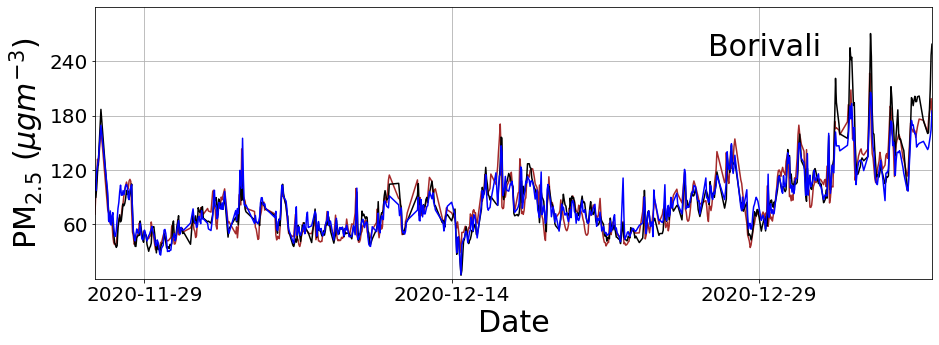

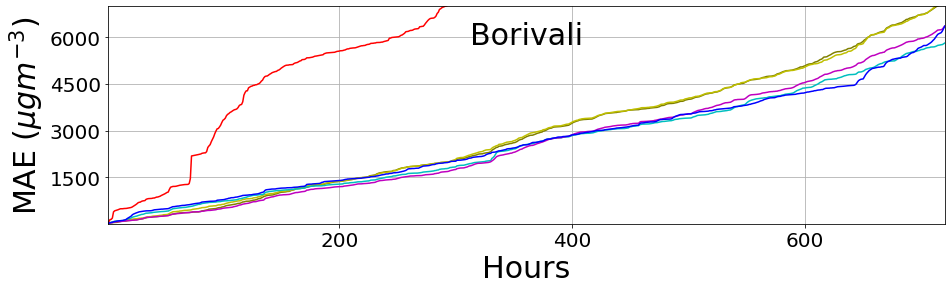

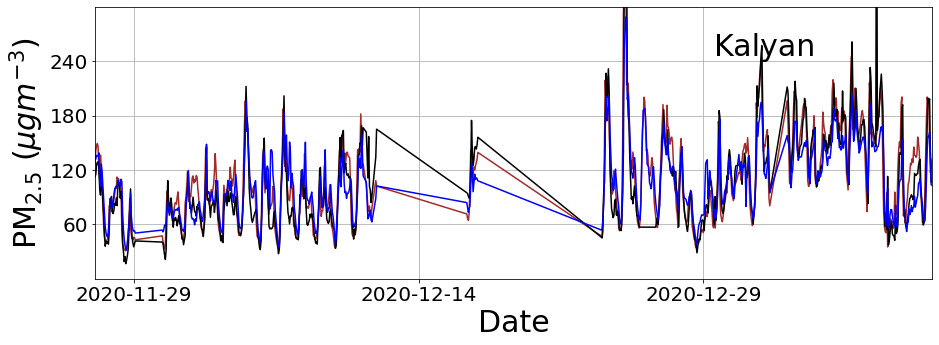

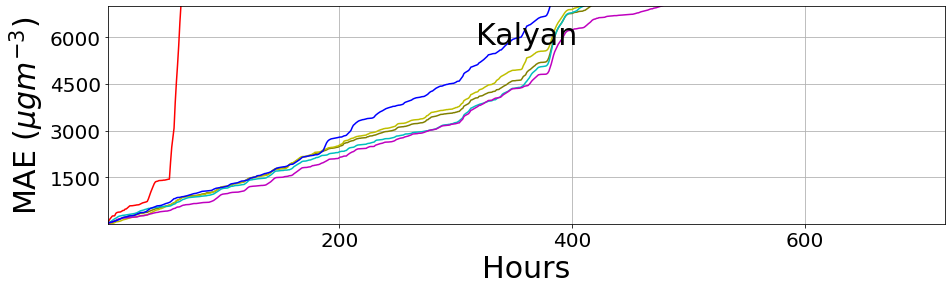

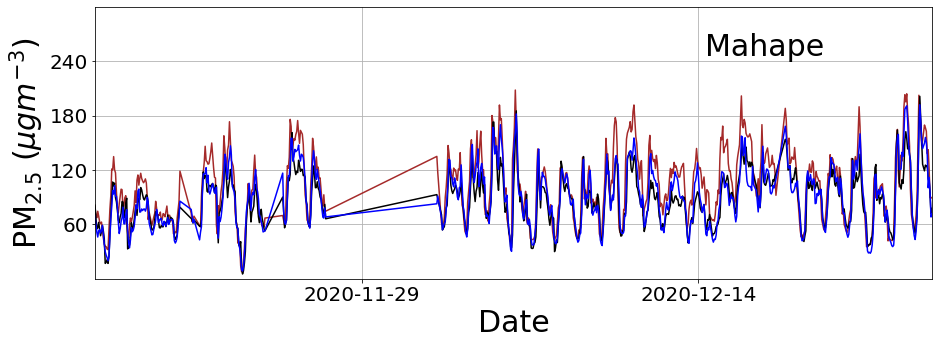

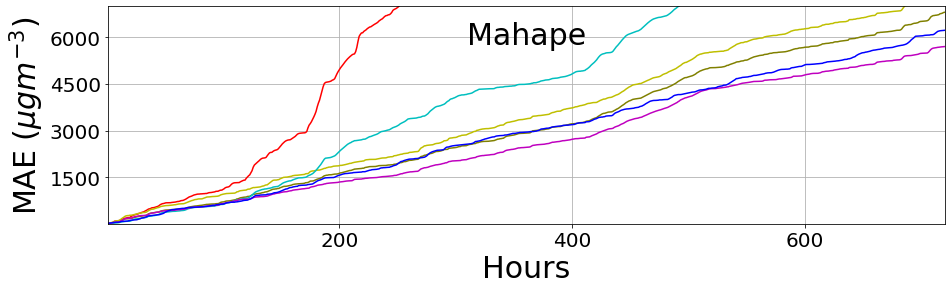

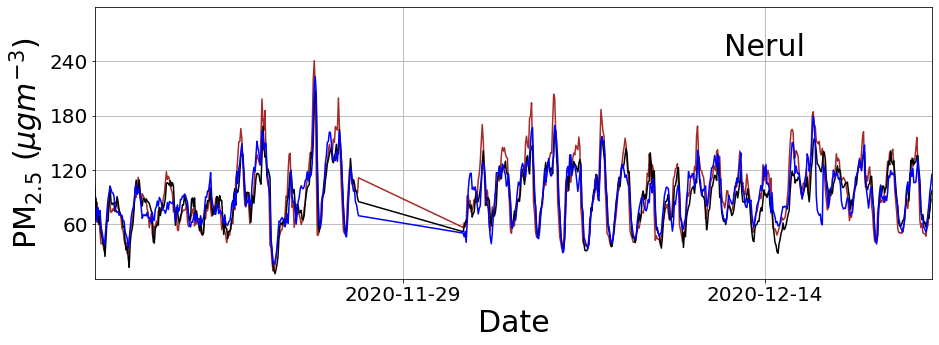

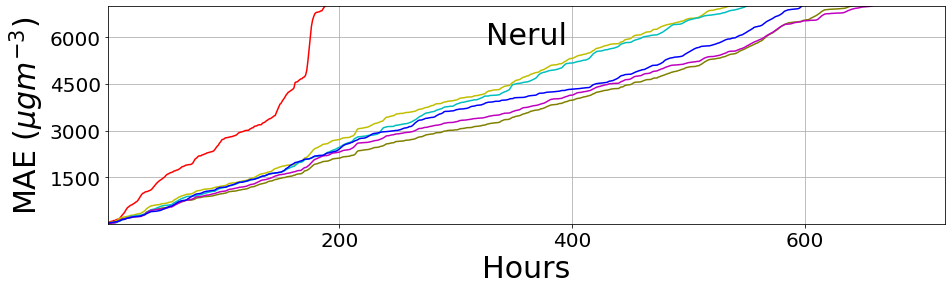

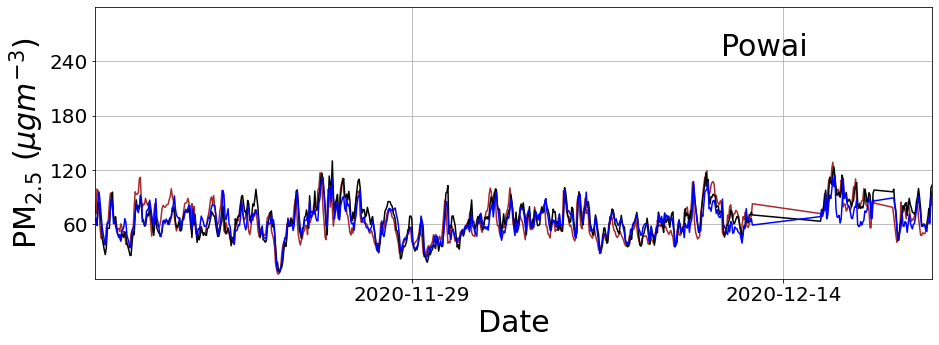

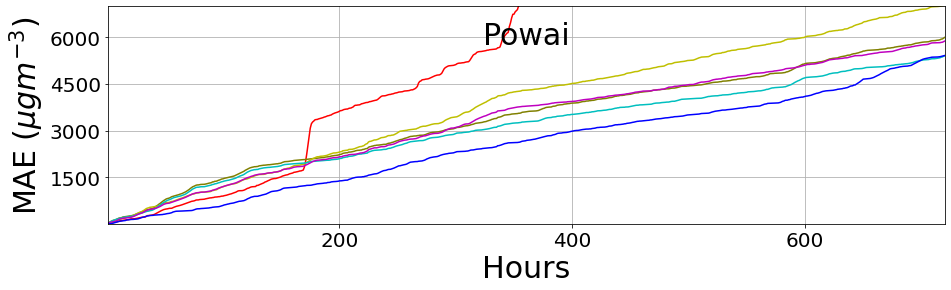

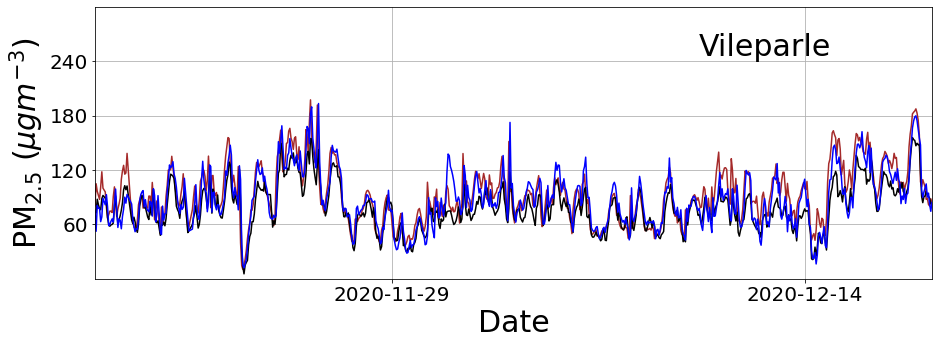

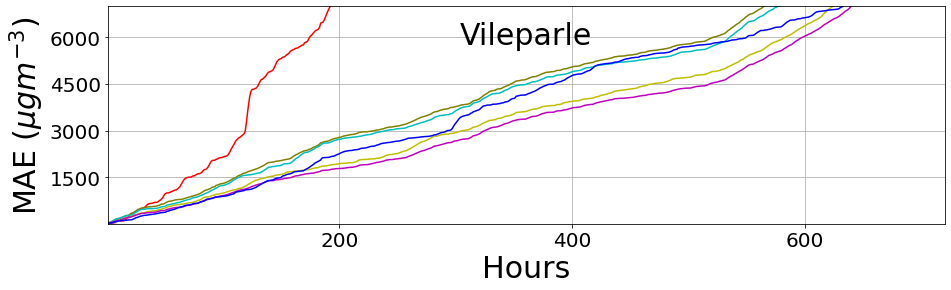

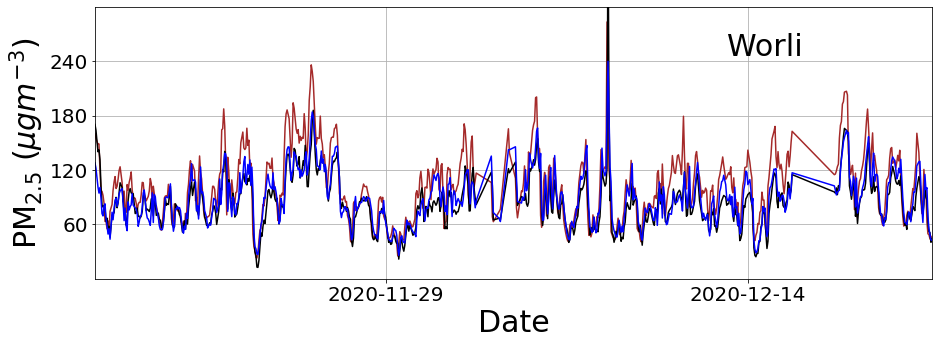

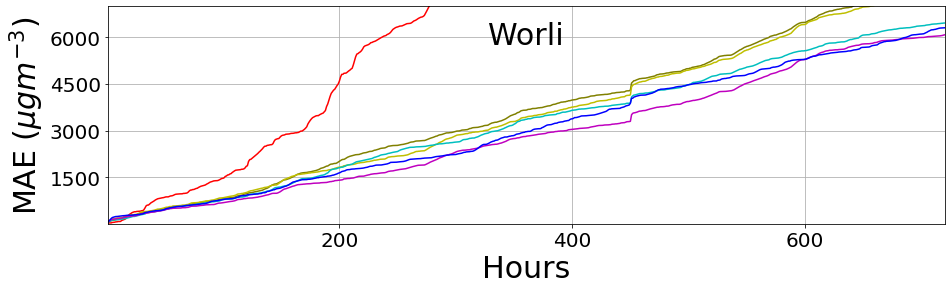

In [3]:
name_list = ['Borivali','Kalyan','Mahape','Nerul','Powai','Vileparle','Worli']
target_domain_adaptation_testing(name_list)